# Final Assignment
General stuff for this doc:
1. If I load data from scources the DOI of this scource will be included in the markdown.
2. If I extract single values. reference from papers the scource will be included in the markdown or the paper
3. data_ouput is safed in csv files and extractable in the respective folder. Same is true for figures.
4. Assumptions are as explicityl stated.

## Loading the data
First we need to import the DWT per cluster. Please assess the clustering in the file. For clustering we use:
<https://www.routledge.com/The-Global-North-South-Atlas-Mapping-Global-Change/Solarz/p/book/9781138588844>

What does flag of regristration mean:In the context of maritime transport statistics, the "flag of registration" refers to the country under whose laws a ship is registered and operates. Here there are multible Assumptions involved.

1. where a ship is registrated it is build and in EOL destructed and partially recycled.
2.


The data scource for the DWT is <https://unctadstat.unctad.org/wds/TableViewer/tableView.aspx?ReportId=93>
Unit: 10**3 DWT

The material_intensity, lifetime and DWT_to_GT  is extracted from <https://doi.org/10.1016/j.gloenvcha.2022.102493>

For the model look at the file MODEL.drawio


In [2]:
import pandas as pd
import numpy as np

DWT = pd.read_excel('final_assignment_data.xlsx', sheet_name='raw_Fleet_DWT')

#lets clean up the mess we want to drop first column and the rows of column YEAR containing the Total fleet

DWT_clean = DWT.drop(DWT.columns[0], axis=1).drop(DWT[(DWT['YEAR'] == 'Total fleet') | (DWT['classification'] == 'none')].index)


print(DWT_clean)


                     YEAR classification      1980      1981      1982   
20            Oil tankers          south  3161.677  3092.309   2930.42  \
21          Bulk carriers          south   260.628   261.228   421.198   
22          General cargo          south  1044.468  1108.328  1152.824   
23        Container ships          south        ..     1.277     1.297   
24   Other types of ships          south   483.573    497.67   598.965   
..                    ...            ...       ...       ...       ...   
158           Oil tankers          north   652.876   694.559   737.673   
159         Bulk carriers          north  1459.792  1388.981  1580.195   
160         General cargo          north   560.798   509.863   479.782   
161       Container ships          north   130.448   130.448   131.291   
162  Other types of ships          north   126.605   124.613   150.603   

         1983      1984      1985      1986      1987  ...          2013   
20    3059.61  3174.266  3083.538  

#perfect now we build a dict with the first key class and the second type of ship which contains the mean of each year. And the standard deviation.
for both we use a tuple key with (class,type) containing a DataFrame with the yearly averages.

WE derive an DWT error in the intervall of 50% DWT_err = [.5, 1.5]

In [3]:

DWT_mean = {}
DWT_stdev ={}

classification = ['south', 'north']
type_ships = ['Oil tankers', 'Bulk carriers', 'General cargo', 'Container ships', 'Other types of ships']

for class_ in classification:
    for type_ in type_ships:
        subset = DWT_clean[(DWT_clean['classification'] == class_) & (DWT_clean['YEAR'] == type_)].drop(['YEAR', 'classification'], axis=1)
        DWT_mean[(class_, type_)] = pd.concat([subset.apply(pd.to_numeric, errors='coerce').mean(),subset.apply(pd.to_numeric, errors='coerce').std()],axis=1)

print(DWT_mean)



{('south', 'Oil tankers'):                  0             1
1980  13109.524455  30808.245755
1981  13187.626273  30666.475522
1982  12814.700091  27914.367622
1983  12507.639091  25418.473973
1984  12293.725455  23786.716346
1985  11515.484091  20796.158546
1986  10744.916182  18714.836401
1987  10504.233636  16794.057048
1988  10820.723091  16369.521597
1989  10396.398273  16000.149616
1990  10654.272727  15286.003376
1991  10916.000000  16037.212401
1992  12028.898455  15951.502309
1993  12850.331091  16892.233338
1994  12910.698364  16563.050856
1995  12212.300417  16990.107778
1996  12261.234833  17416.687390
1997  12699.205417  17405.658946
1998  12661.409917  17091.838890
1999  13249.323667  17740.048290
2000  12824.173750  16472.152370
2001  13113.083333  17425.386274
2002  13142.916667  17790.343788
2003  14125.583333  19039.496047
2004  14544.352750  18642.771681
2005  15453.500000  19643.237770
2006  16739.427000  21463.945898
2007  17623.365000  22730.339102
2008  18760.7145

we have now for every combination a DataFrame with mean, stdev for every year. the stdev here kind of an aggregation error is quite high but thats OK as we assess the uncertainty of this aggregation (hopefully) timeframe is quite tight

new lets get stuff translated to GT

In [4]:
DWT_to_GT =  pd.read_excel('final_assignment_data.xlsx', sheet_name='DWT_to_GT')

print(DWT_to_GT)

  https://doi.org/10.1016/j.gloenvcha.2022.102493  Oil tankers  Bulk carriers   
0                                               m       0.5452         0.5496  \
1                                              n        1.0000         1.0000   
2                                              t    20259.0000     29551.0000   
3                                              R2       0.9997         0.9998   

   General cargo  Container ships  Other types of ships  
0         0.7637           0.9485                2.2005  
1         1.0145           0.9857                0.8935  
2         0.0000           0.0000                0.0000  
3         0.9988           0.9785                0.9772  


this is to interpret alla y = m*x^n +t

In [5]:
DWT_to_GT.iloc[0,0]=0

DWT_to_GT.index = ['m','n','t','r2']



In [6]:
GT_mean = {(class_, type_): DWT_to_GT.loc['m', type_] * DWT_mean[(class_, type_)][0] ** DWT_to_GT.loc['n', type_] + DWT_to_GT.loc['t', type_] for class_ in classification for type_ in type_ships}


fck we need the life times lets get them

In [7]:
lifetime = pd.read_excel('final_assignment_data.xlsx', sheet_name='lifetime')

For the lifetime we include an lifetime_err = [.8,1.2] see <https://doi.org/10.1016/j.gloenvcha.2022.102493 >

In [8]:
print(lifetime)

  https://doi.org/10.1016/j.gloenvcha.2022.102493  Oil tankers  Bulk carriers   
0                            Average lifetime (y)         26.7           26.8  \

   General cargo  Container ships  Other types of ships  
0           21.9             32.7                  33.5  


Assumption: Because of no better value in the literature and the relative unimportance of the scale of the distribution the scale was held constant for every ship catagory at scale=10. However this obviously a point to further investigate.


The scenarios are not included so far. the results will be adapted for every scenario combination. Proposed structure

DataFrame in dict [class_, type_] in dict [growth, decoupling_factor]

In [9]:
from stock_flow_model import *

ships_results = {(class_, type_): stock_driven_model(time=GT_mean[class_,type_].index ,stock=GT_mean[class_,type_].values,loc= lifetime.loc[0,type_])[0] for class_ in classification for type_ in type_ships}

print(ships_results)

# todo adapt fcking survival curve and take care of you vocab. Here we have also the first non linearities


{('south', 'Oil tankers'):       survival_curve        inflow      outflow         stock           nas
1980        0.996207  27510.648583   104.335850  27406.312733  27406.312733
1981        0.994915     78.432326    35.851215  27448.893844     42.581111
1982        0.993244   -157.853882    45.465472  27245.574490   -203.319354
1983        0.991106   -109.067773    58.341885  27078.164832   -167.409657
1984        0.988396    -42.476828    74.148886  26961.539118   -116.625715
1985        0.984997   -332.393889    91.903302  26537.241926   -424.297191
1986        0.980774   -305.998445   114.115179  26117.128302   -420.113624
1987        0.975581     10.138862   141.358986  25985.908179   -131.220124
1988        0.969258    345.849843   173.299792  26158.458229    172.550051
1989        0.961636    -23.775158   207.566733  25927.116338   -231.341891
1990        0.952540    389.774862   249.181709  26067.709491    140.593153
1991        0.941792    437.420914   294.727205  26210.403200

perfect now we have to initialize the inflow driven model for the steal. The structure of the dictionary will be analogues. of course we need to import the material intensities. and convert them in the right unit.

Source:<https://doi.org/10.1016/j.gloenvcha.2022.102493>

Unit: kg/GT -> transformation in 10**-3 kg/ GT

for the uncertainty analysis we go for a MI error of

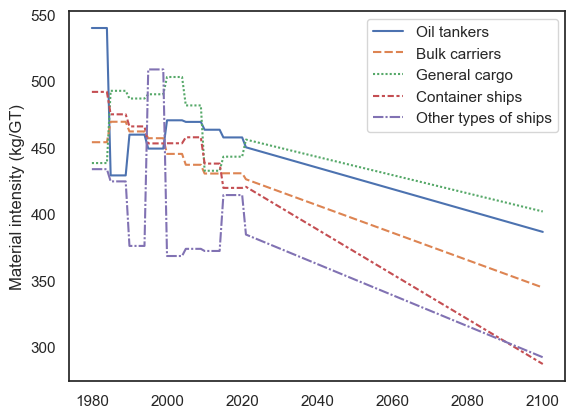

In [10]:
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

material_intensity_raw =  pd.read_excel('final_assignment_data.xlsx', sheet_name='material_intensity')

material_intensity_raw.index = material_intensity_raw['Unnamed: 0']

material_intensity_raw.drop('Unnamed: 0', axis=1, inplace=True)#.drop('Unnamed: 0', axis=0, inplace=True)

material_int = pd.DataFrame(columns=material_intensity_raw.columns, index = range(1980,2101))

for inter in range(1985,2025,5):
    for column in material_intensity_raw.columns:
        material_int.loc[inter-5:inter,column] = material_intensity_raw.loc[inter,column]*10**3

for column in material_int.columns:
    regr = linregress(range(1980, 2021), pd.to_numeric(np.array(material_int.loc[:2020, column])))
    material_int.loc[2021:, column] = np.array(range(2021,2101)) * regr.slope + regr.intercept



sns.set_theme(style='white')
sns.lineplot(material_int/10**3)
plt.ylabel('Material intensity (kg/GT)')
plt.show()



In [11]:
print(material_intensity_raw.describe())

       Oil tankers  Bulk carriers  General cargo  Container ships   
count     9.000000       9.000000       9.000000         9.000000  \
mean    489.400000     433.533333     471.388889       453.400000   
std      72.994674      45.851009      26.403619        22.893012   
min     428.900000     316.900000     432.400000       419.500000   
25%     457.500000     430.500000     443.000000       437.800000   
50%     463.300000     445.100000     481.600000       453.100000   
75%     470.400000     456.900000     490.000000       465.800000   
max     666.700000     469.300000     503.000000       491.800000   

       Other types of ships  
count              9.000000  
mean             408.722222  
std               44.996633  
min              368.200000  
25%              373.600000  
50%              408.100000  
75%              424.400000  
max              508.700000  


for the Material intensity error Mat_err we assume 20%-> mat_int = [.8,1.2]

In [12]:
steel_results = {(class_, type_): flow_driven_model(time=ships_results[class_,type_].index ,inflow=ships_results[class_,type_]['inflow'].values*material_int.loc[:2022,type_].values,sf_kind='normal',loc= lifetime.loc[0,type_],stock_ini=ships_results[class_,type_].loc['1980','stock'])[0] for class_ in classification for type_ in type_ships}

print(steel_results)

{('south', 'Oil tankers'):       survival_curve             inflow           outflow               stock   
1980        0.996207  14852999169.74192     56358331.7141  14796668244.340553  \
1981        0.994915    42345612.879743   19356070.903594  14819657786.316702   
1982        0.993244   -85225311.150179   24546808.251114  14709885666.915409   
1983        0.991106   -58885690.455835   31498783.466444   14619501192.99313   
1984        0.988396    -22933239.47843   40032983.804662  14556534969.710037   
1985        0.984997  -142563739.007051   49758522.301234  14364212708.401752   
1986        0.980774   -131242733.11895   61787285.286669  14171182689.996134   
1987        0.975581     4348557.823349   76420986.976197  14099110260.843287   
1988        0.969258   148334997.476582   93553154.355409   14153892103.96446   
1989        0.961636   -10197165.328174  112196404.833613  14031498533.802673   
1990        0.952540   179140526.496137  134568838.350322  14076070221.948488   
1

# Scenario Development

1. The basic idea here is to find predictor functions that correlate GT with GDP in the time window (1980-2022) F(x)
    This assumption seems valid following: https://www.sciencedirect.com/science/article/pii/S0959378022000310
2. This predictor function we apply to SSP scenarios from: <https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=60>
3. We find a proxy for GT in time window 2022-2100 and append. haha hopefully this works


## 1. get predictors

1. load data
2. define prediction dict
3. load input data from SSP
4. linearize over time interval

Lets do this.


In [13]:
GDP = pd.read_excel('final_assignment_data.xlsx', sheet_name='GDP')

print(GDP.info)

<bound method DataFrame.info of     World Development Indicators | DataBank (worldbank.org)     Series Code   
0                                    GDP (current US$)       NY.GDP.MKTP.CD  \
1                                    GDP (current US$)       NY.GDP.MKTP.CD   
2                                    GDP (current US$)       NY.GDP.MKTP.CD   
3                                    GDP (current US$)       NY.GDP.MKTP.CD   
4                                    GDP (current US$)       NY.GDP.MKTP.CD   
..                                                 ...                  ...   
266                                                NaN                  NaN   
267                                                NaN                  NaN   
268                                                NaN                  NaN   
269   Data from database: World Development Indicators                  NaN   
270                           Last Updated: 05/10/2023                  NaN   

       Country Name

In [14]:
GDP_clean = GDP.dropna(subset=['classification']).iloc[:,3:].drop('Country Code', axis=1)

GDP_clean.columns = [str(1959 + i) if i != 0 else GDP_clean.columns[0] for i in range(len(GDP_clean.columns))]

GDP_clean.drop('2022',axis=1, inplace=True)

print(GDP_clean)

    classification                  1960                  1961   
0            South      537777811.111111      548888895.555556  \
1            North                    ..                    ..   
2            South     2723593384.780539     2434727329.808997   
3            South                    ..                    ..   
4            North                    ..                    ..   
..             ...                   ...                   ...   
261           none    31164466286.572659    32419973709.181084   
262           none    31153393537.819958    32409476929.026722   
263           none    31164466286.572659    32419973709.181084   
264           none   241947821260.231689   218362178293.655212   
265           none  1392273064404.333252  1448621687210.334717   

                     1962                  1963                  1964   
0        546666677.777778      751111191.111111      800000044.444444  \
1                      ..                    ..              

The GDP_data comes with high uncertainty. we go for and GDP err of GDP_err = [.5,1.5]

In [15]:
classification_ad = ['South','North']
GDP_class = dict()

for class_ in classification_ad:
    subset_1 = GDP_clean[GDP_clean['classification'] == class_].drop('classification', axis=1)
    GDP_class[class_] = pd.concat([subset_1.apply(pd.to_numeric, errors='coerce').mean(),subset_1.apply(pd.to_numeric, errors='coerce').std()],axis=1)

# how tricky can it be to simple switch fcking keys
def keys_swap(orig_key, new_key, d):
    d[new_key] = d.pop(orig_key)

keys_to_swap = {'South': 'south', 'North': 'north'}
for orig_key, new_key in keys_to_swap.items():
    if orig_key in GDP_class:
        keys_swap(orig_key, new_key, GDP_class)


print(GDP_class)

{'south':                  0             1
1960  3.227687e+09  8.505497e+09
1961  3.039989e+09  7.649130e+09
1962  3.382059e+09  7.978482e+09
1963  3.666941e+09  8.650021e+09
1964  4.055776e+09  1.004259e+10
...            ...           ...
2017  2.158413e+11  1.062089e+12
2018  2.297453e+11  1.186817e+12
2019  2.348580e+11  1.222590e+12
2020  2.273864e+11  1.251848e+12
2021  2.700086e+11  1.523525e+12

[62 rows x 2 columns], 'north':                  0             1
1960  3.416723e+10  1.036660e+11
1961  3.620831e+10  1.075222e+11
1962  3.905309e+10  1.155361e+11
1963  4.203909e+10  1.220179e+11
1964  4.590740e+10  1.311143e+11
...            ...           ...
2017  7.864874e+11  2.588040e+12
2018  8.344671e+11  2.726731e+12
2019  8.586469e+11  2.847876e+12
2020  8.654009e+11  2.845809e+12
2021  1.030304e+12  3.240401e+12

[62 rows x 2 columns]}


WE leverage here linear regression from scipy
x: GDP (INPUT) in $
y: GT (WHAT WE WANT TO PREDICT) in

In [16]:
from scipy.stats import linregress

regress = {(class_, type_): linregress(GDP_class[class_].iloc[20:,0], GT_mean[class_,type_][:-1] )for type_ in type_ships for class_ in classification}

print(regress)

{('south', 'Oil tankers'): LinregressResult(slope=2.9898383293618353e-08, intercept=26010.159789089492, rvalue=0.9767830061010376, pvalue=2.203949186937843e-28, stderr=1.0368169951166663e-09, intercept_stderr=124.95666225255262), ('north', 'Oil tankers'): LinregressResult(slope=1.5642070539178394e-08, intercept=25393.688398957715, rvalue=0.708105964465279, pvalue=1.5600500720328822e-07, stderr=2.4662438023115702e-09, intercept_stderr=1446.515763386279), ('south', 'Bulk carriers'): LinregressResult(slope=6.259830623278284e-08, intercept=33746.142676953845, rvalue=0.98817466320182, pvalue=3.376562094149348e-34, stderr=1.5357937616287558e-09, intercept_stderr=185.09309093629162), ('north', 'Bulk carriers'): LinregressResult(slope=3.729350937840095e-08, intercept=24802.49863397339, rvalue=0.8443374185311492, pvalue=2.1286217183434026e-12, stderr=3.741963302105174e-09, intercept_stderr=2194.7582381899024), ('south', 'General cargo'): LinregressResult(slope=-4.2563946055718045e-09, intercept

## 2. LOAD Prediction INPUT data

we do not load SSP scenarios because they cannot predict the right magnitude of the outcome because of different aggregation methods.-> we load relative values


changing parameter:
1. Growth rate south/north (SSP2 2.6, SSP1 2.6, Degrwoth). We take here the relative values from south (OPEC) and average ROW for north. Growth rates are linearised over the decades.
2. The growth rate of the oil tankers approximated via the relative growth rate of the primary energy oil indicator.
    (SSP2 2.6, SSP1 2.6) Of course and assumption is that there is causal relation between GT (Oil tanker) and the respective global primary energy demand but this seems quite valid.
3. Therefore we have 6 scenarios.
4. Now we need fancy names for them

Quick note: the scenarios were purpusly choosen to be the optimistic ones because this study wants to elaborate if it is possible to see stock saturation in the merchant ship fleet and under shich circumstances.

For the SSP data the change rates are under deep uncertainty. we go also for rate_err = [.7,1.3]

same for the degrowth rate. degr_rate_err = [.7,1.3]


In [17]:
scenario_names = ['SSP1-26', 'SSP2-26']

rates= {} #key one kind key 2 scenario key 3 class

calc_rates = pd.read_excel('final_assignment_data.xlsx', sheet_name='scenario_data')


for class_ in classification:
    for kind in ['GDP|PPP','Primary Energy|Oil']:
        for scenario in ['SSP1-26', 'SSP2-26']:

            GDP_dec_mean= calc_rates[(calc_rates['clustering']==class_ ) & (calc_rates['VARIABLE']==kind) & (calc_rates['SCENARIO']==scenario)].loc[:,2020:].mean()
            GDP_dec_diff = GDP_dec_mean.diff().div(GDP_dec_mean.shift()) /10
            rates[(class_, kind, scenario)]= GDP_dec_diff

rates[('north', 'GDP|PPP', 'degrowth')] = pd.Series([-.0053]*9,index=[2020+10*i for i in range(9)])
rates[('south', 'GDP|PPP', 'degrowth')] = pd.Series([-.0053]*9,index=[2020+10*i for i in range(9)])

print(rates)


{('south', 'GDP|PPP', 'SSP1-26'): 2020         NaN
2030    0.074634
2040    0.054766
2050    0.036687
2060    0.025653
2070    0.019564
2080    0.014619
2090    0.011192
2100    0.008058
dtype: float64, ('south', 'GDP|PPP', 'SSP2-26'): 2020         NaN
2030    0.059172
2040    0.037994
2050    0.029462
2060    0.024530
2070    0.022515
2080    0.020627
2090    0.019052
2100    0.017716
dtype: float64, ('south', 'Primary Energy|Oil', 'SSP1-26'): 2020         NaN
2030    0.000669
2040   -0.006906
2050   -0.004343
2060   -0.003590
2070   -0.012495
2080   -0.033424
2090   -0.031664
2100   -0.011328
dtype: float64, ('south', 'Primary Energy|Oil', 'SSP2-26'): 2020         NaN
2030   -0.017395
2040   -0.013026
2050   -0.011905
2060   -0.035456
2070   -0.029919
2080   -0.016142
2090   -0.021242
2100   -0.000980
dtype: float64, ('north', 'GDP|PPP', 'SSP1-26'): 2020         NaN
2030    0.024547
2040    0.022099
2050    0.017314
2060    0.014428
2070    0.013024
2080    0.010650
2090    0.008801


no it is possible to calculate the rest of the GDP values.


In [18]:
GDP_scenario = dict()
scenarios = ['SSP1-26', 'SSP2-26', 'degrowth']

for class_ in classification:
    for scenario in scenarios:
        annual_rates = pd.Series(index=[2020 + i for i in range(81)])
        for i in range(2030, 2110, 10):
            annual_rates.loc[range(i - 10, i)] = 1 + rates[(class_, 'GDP|PPP', scenario)][i]

        initial_GDP = GDP_class[class_].loc['2021', 0]
        GDP_scenario[(class_, scenario)] = annual_rates.cumprod() * initial_GDP

print(GDP_scenario)

{('south', 'SSP1-26'): 2020    2.901603e+11
2021    3.118160e+11
2022    3.350879e+11
2023    3.600967e+11
2024    3.869720e+11
            ...     
2096    2.896888e+12
2097    2.920231e+12
2098    2.943762e+12
2099    2.967482e+12
2100             NaN
Length: 81, dtype: float64, ('south', 'SSP2-26'): 2020    2.859855e+11
2021    3.029078e+11
2022    3.208315e+11
2023    3.398157e+11
2024    3.599233e+11
            ...     
2096    2.483493e+12
2097    2.527490e+12
2098    2.572266e+12
2099    2.617836e+12
2100             NaN
Length: 81, dtype: float64, ('south', 'degrowth'): 2020    2.685775e+11
2021    2.671541e+11
2022    2.657381e+11
2023    2.643297e+11
2024    2.629288e+11
            ...     
2096    1.793373e+11
2097    1.783868e+11
2098    1.774414e+11
2099    1.765009e+11
2100             NaN
Length: 81, dtype: float64, ('north', 'SSP1-26'): 2020    1.055594e+12
2021    1.081506e+12
2022    1.108053e+12
2023    1.135253e+12
2024    1.163120e+12
            ...     
2096   

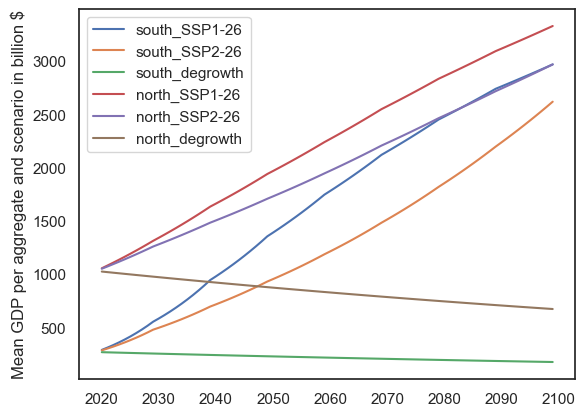

In [19]:
for class_ in classification:
    for scenario in scenarios:
        sns.lineplot(GDP_scenario[(class_, scenario)]/10**9,label=f"{class_}_{scenario}", legend=False
        )
plt.ylabel('Mean GDP per aggregate and scenario in billion $')
plt.legend()
plt.show()

To reduce effort it is assumed that for GT[2100] = GT[2099]

In [20]:
GT_scenario = {(class_, type_, scenario): pd.Series(np.array(GDP_scenario[(class_, scenario)]) * regress[(class_, type_)].slope + regress[(class_, type_)].intercept, index=GDP_scenario[(class_, scenario)].index) for scenario in scenarios for type_ in type_ships for class_ in classification}
print(GT_scenario)

for class_ in classification:
    for type_ in type_ships:
        for scenario in scenarios:
            GT_scenario[(class_, type_, scenario)].loc[2100]=GT_scenario[(class_, type_, scenario)].loc[2099]

print(GT_scenario)


{('south', 'Oil tankers', 'SSP1-26'): 2020     34685.482877
2021     35332.953131
2022     36028.746396
2023     36776.469191
2024     37579.997200
            ...      
2096    112622.432624
2097    113320.345860
2098    114023.882813
2099    114733.088798
2100              NaN
Length: 81, dtype: float64, ('north', 'Oil tankers', 'SSP1-26'): 2020    41905.369325
2021    42310.679127
2022    42725.938010
2023    43151.390192
2024    43587.285886
            ...     
2096    76309.954540
2097    76685.360616
2098    77063.534565
2099    77444.496793
2100             NaN
Length: 81, dtype: float64, ('south', 'Bulk carriers', 'SSP1-26'): 2020     51909.684363
2021     53265.294159
2022     54722.077941
2023     56287.586684
2024     57969.934919
            ...      
2096    215086.435401
2097    216547.657770
2098    218020.654527
2099    219505.520547
2100              NaN
Length: 81, dtype: float64, ('north', 'Bulk carriers', 'SSP1-26'): 2020     64169.315573
2021     65135.647037
2022

In [21]:
GT_results_scenario ={}

GT_results_scenario = {(class_, type_, scenario): flow_driven_model(time = range(2023,2101),inflow=GT_scenario[(class_,type_,scenario)].loc[2023:].values , sf_kind='normal',loc= lifetime.loc[0,type_],stock_ini=ships_results[class_,type_].loc['2022','stock'])[0] for scenario in scenarios for class_ in classification for type_ in type_ships}

print(GT_results_scenario)

{('south', 'Oil tankers', 'SSP1-26'):       survival_curve         inflow       outflow         stock           nas
2023    9.962074e-01   36776.469191  34746.365988  3.663699e+04   2030.103202
2024    9.949151e-01   37579.997200    190.053045  7.402694e+04  37389.944154
2025    9.932443e-01   38443.495365    255.809801  1.122146e+05  38187.685564
2026    9.911060e-01   39371.439474    340.429951  1.512456e+05  39031.009523
2027    9.883962e-01   40368.639355    448.227057  1.911660e+05  39920.412298
...              ...            ...           ...           ...           ...
2096    1.828329e-06  112622.432624  88326.762365  2.726905e+06  24295.670259
2097    1.122599e-06  113320.345860  89367.449273  2.750858e+06  23952.896587
2098    6.826653e-07  114023.882813  90397.113756  2.774484e+06  23626.769056
2099    4.111481e-07  114733.088798  91415.475250  2.797802e+06  23317.613547
2100    2.452399e-07  114733.088798  92419.561045  2.820116e+06  22313.527753

[78 rows x 5 columns], ('

In [22]:
steel_results_scenario={}

steel_results_scenario = {(class_, type_, scenario): flow_driven_model(time = range(2023,2101),inflow=GT_results_scenario[(class_,type_,scenario)].loc[2023:, 'inflow'].values * material_int.loc[2023:,type_].values , sf_kind='normal',loc= lifetime.loc[0,type_],stock_ini=steel_results[class_,type_].loc['2022','stock'])[0] for scenario in scenarios for class_ in classification for type_ in type_ships}

print(steel_results_scenario)


{('south', 'Oil tankers', 'SSP1-26'):       survival_curve              inflow             outflow   
2023    9.962074e-01  16492545360.082497  16178256742.529543  \
2024    9.949151e-01  16822587540.796511     85115074.115608   
2025    9.932443e-01  17178130984.045139    114444567.719028   
2026    9.911060e-01  17561026973.301453    152175120.755333   
2027    9.883962e-01  17973261081.467148     200223816.47036   
...              ...                 ...                 ...   
2096    1.828329e-06  43876522512.321503  36265107709.534882   
2097    1.122599e-06  44057045346.106224  36622196362.482323   
2098    6.826653e-07  44238624514.586906  36973111873.014153   
2099    4.111481e-07  44421263958.331009  37317764698.886917   
2100    2.452399e-07  44328747912.773491   37655026224.87896   

                     stock                 nas  
2023    16429996353.532354    314288617.552954  
2024    33167468820.213257  16737472466.680902  
2025    50231155236.539368  17063686416.326111

In [23]:
print(steel_results['north','Oil tankers'].loc['2022','stock'])

20739258432.830315


# Visualization

no its getting interesting we visualize results. Goal is to have for every

## Analysis of hist data

## Analysis of scenarios:

First we need to prepare data in a

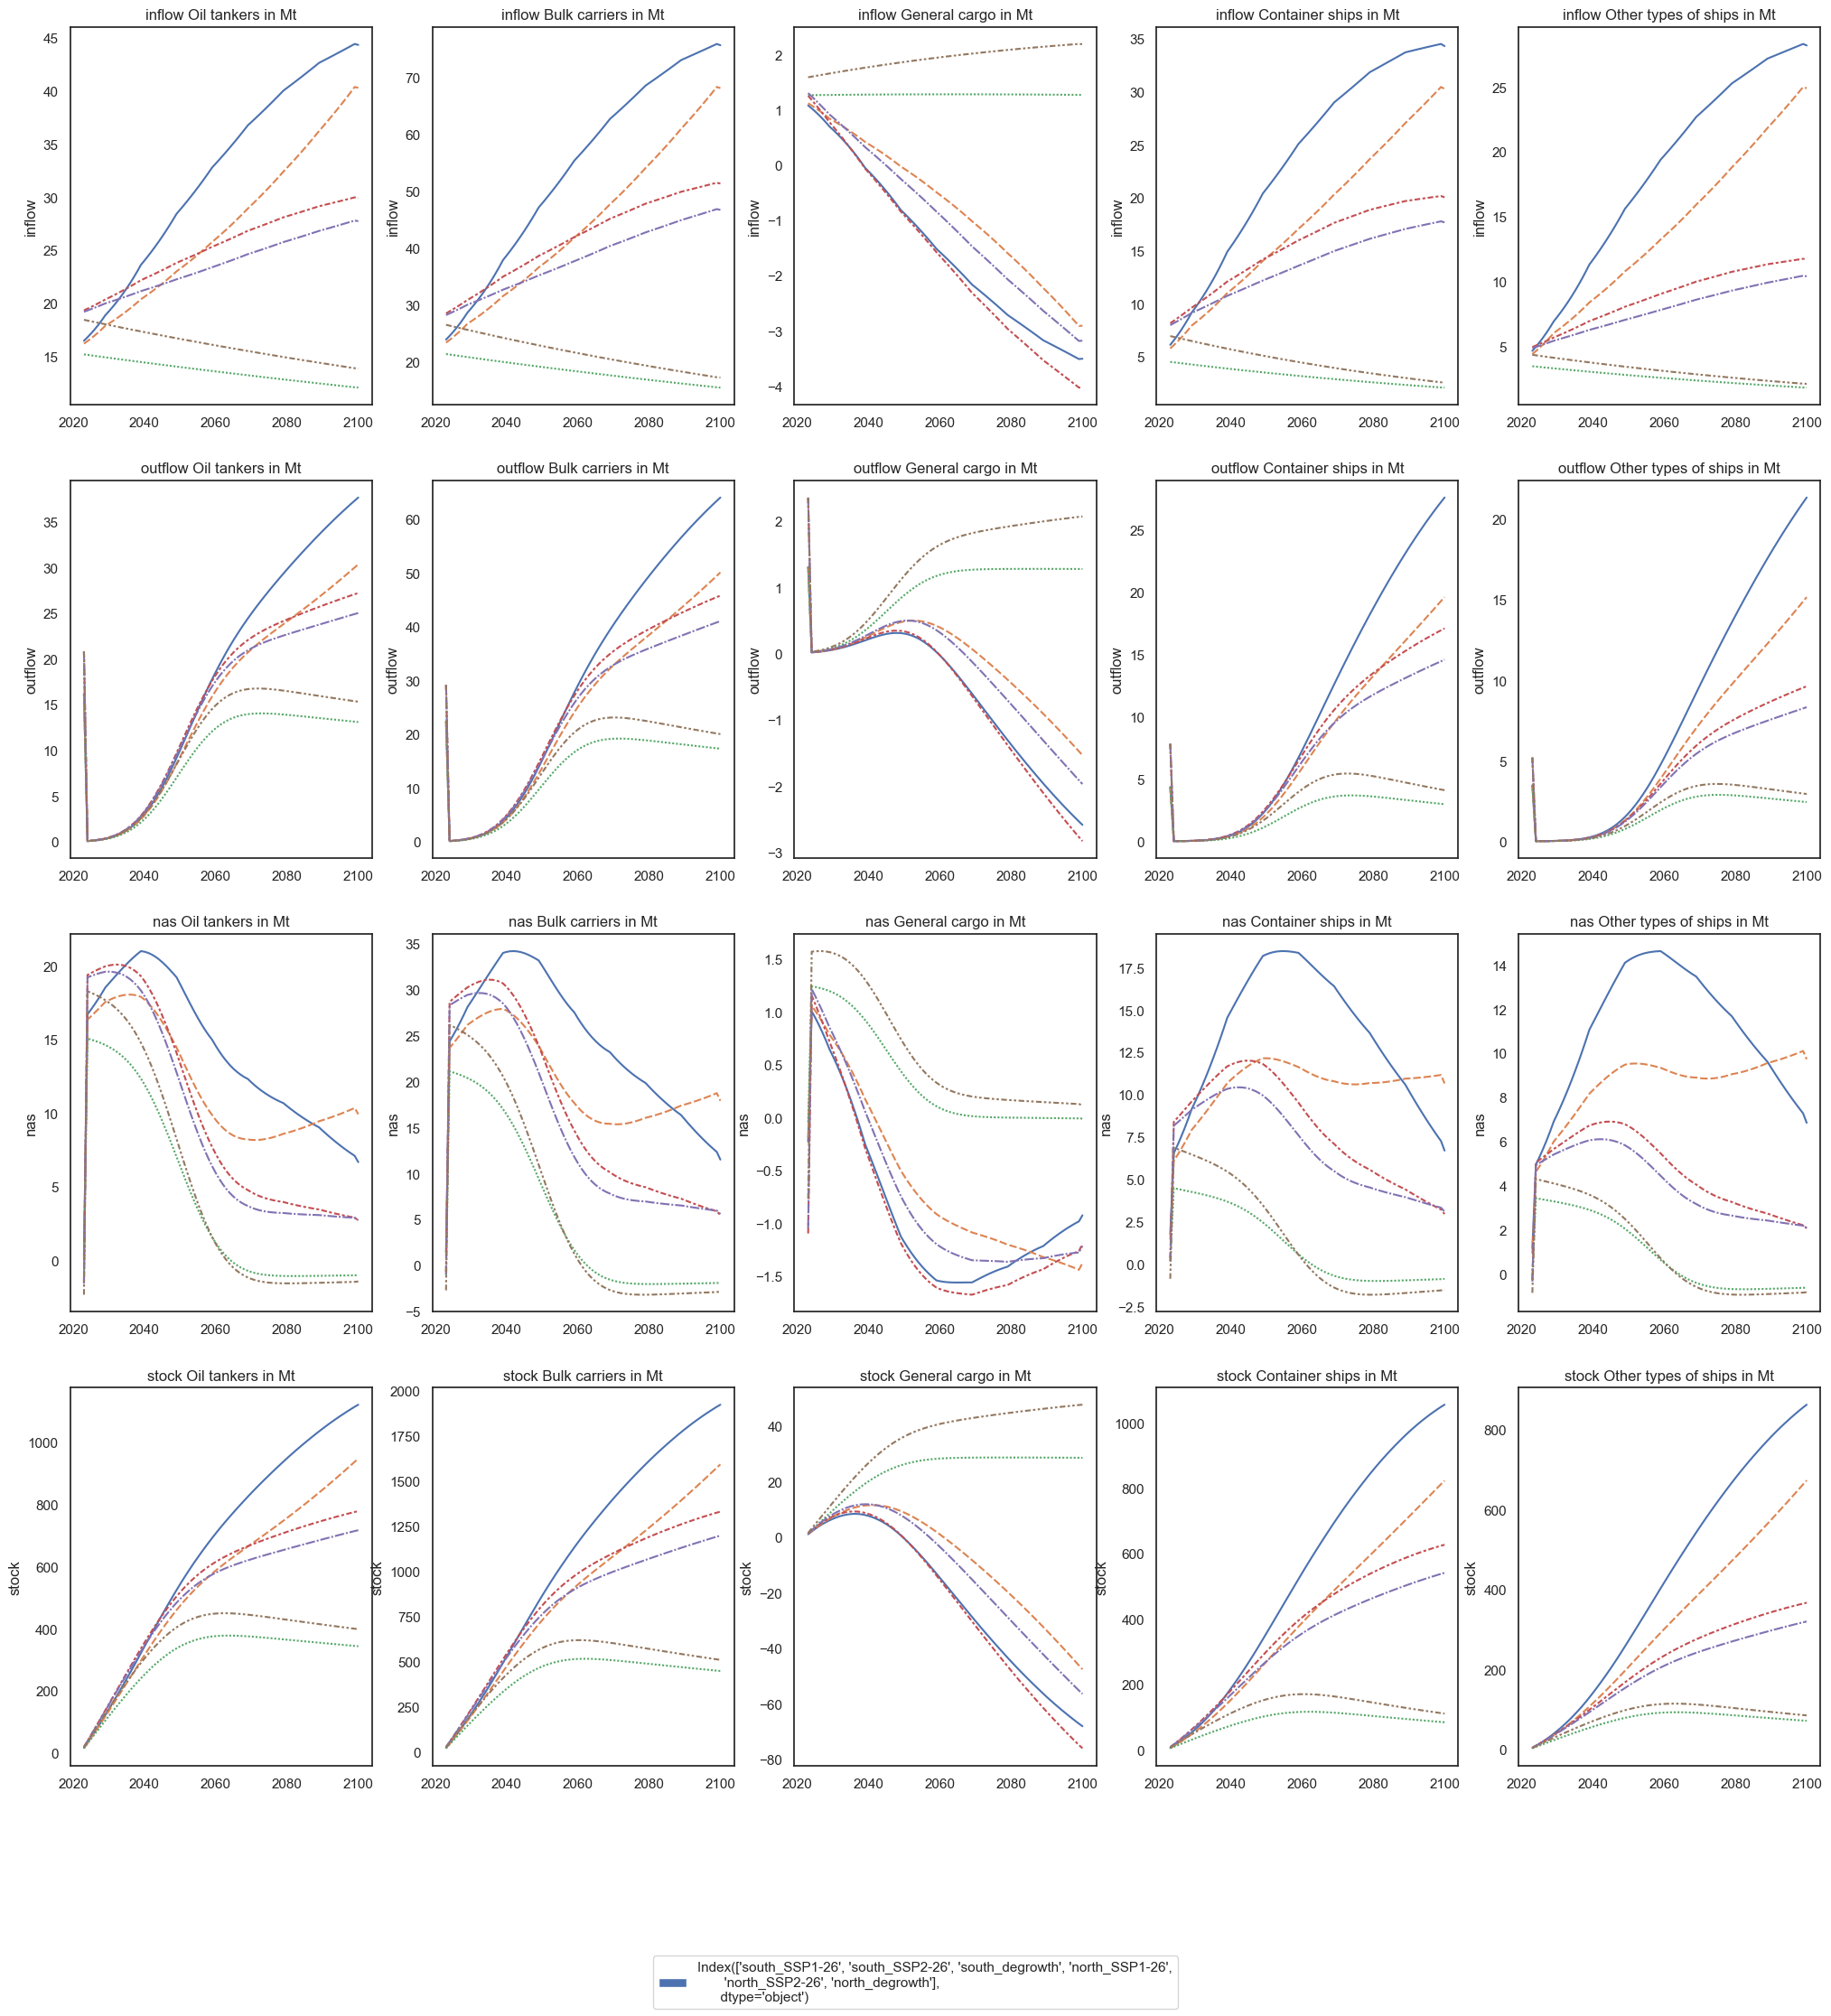

In [24]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(4, 5, figsize=(25, 25), sharey=False)

for j, type_ in enumerate(type_ships):
    for i, column in enumerate(["inflow", "outflow", "nas", "stock"]):

        sns.lineplot(
            data=steel_results[(class_, type_)].loc[:, column].reindex(range(1980,2023)), ax=ax[i, j], label=f"{class_}_hist", legend=False
        )

        agg = pd.DataFrame()
        for class_ in classification:
            for scenario in scenarios:
                agg[f"{class_}_{scenario}"] = steel_results_scenario[(class_, type_, scenario)][column] / 10**9
                agg[f"{class_}_{scenario}"].reindex(range(2023,2101))
                lable = agg.columns

        sns.lineplot(
            data=agg, ax=ax[i, j], label=agg.columns, legend=False
        )

        ax[i, j].set_title(f"{column} {type_} in Mt")


# Create a single legend using proxy artists
legend_patches = [mpatches.Patch(label=lable) ]
fig.legend(handles=legend_patches, loc='lower center')

#plt.tight_layout()
plt.show()

## Cummulated stock and flows

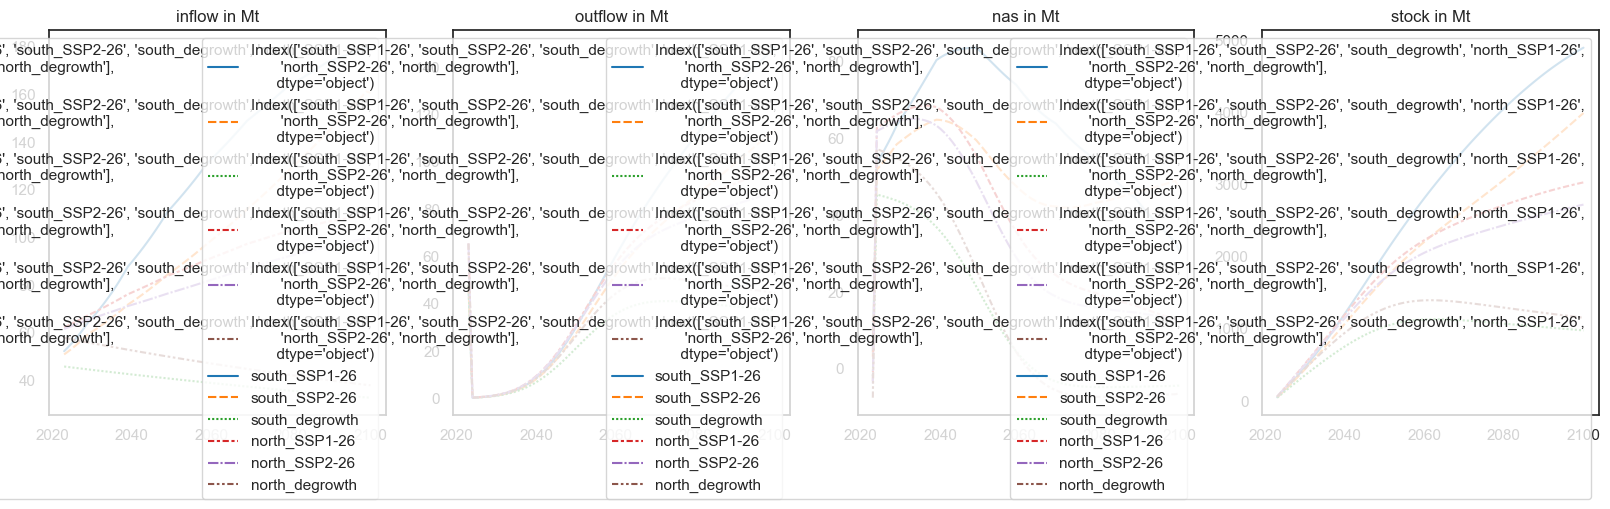

In [25]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=False)


for i, column in enumerate(["inflow", "outflow", "nas", "stock"]):
    agg_sum = pd.DataFrame()

    for class_ in classification:
        for scenario in scenarios:
            agg = pd.DataFrame()
            for type_ in type_ships:
                agg[f"{type_}"] = steel_results_scenario[(class_, type_, scenario)][column] / 10**9
                agg_sum[f"{class_}_{scenario}"] = agg.sum(axis =1)
                lable = agg_sum.columns

    sns.lineplot(
        data=agg_sum,ax=ax[i] ,label=agg_sum.columns, legend=True , palette='tab10'
    )

    ax[i].set_title(f"{column} in Mt")


#plt.tight_layout()
#plt.legend(labels=lable,loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()

## Indicator calculation & visualization

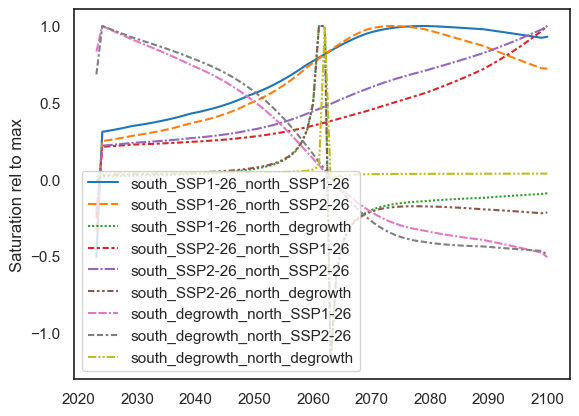

In [26]:
agg_sum = pd.DataFrame()
for class_ in classification:
        for scenario in scenarios:
            agg = pd.DataFrame()
            for type_ in type_ships:
                agg[f"{type_}"] = steel_results_scenario[(class_, type_, scenario)]['nas'] / 10**9
                agg_sum[f"{class_}_{scenario}"] = agg.sum(axis =1)
                lable = agg_sum.columns


nas_indic = pd.DataFrame()
for scenario in scenarios:
    for scenario_1 in scenarios:
        nas_indic[f"south_{scenario}_north_{scenario_1}"] = agg_sum[f"south_{scenario}"] / agg_sum[f"north_{scenario_1}"]

nas_indic = nas_indic.fillna(0)  # Replace NaN values with 0


nas_indic['south_SSP1-26_north_degrowth'].loc[2062] = nas_indic['south_SSP1-26_north_degrowth'].loc[2061]
nas_indic['south_SSP2-26_north_degrowth'].loc[2062] = nas_indic['south_SSP2-26_north_degrowth'].loc[2061]

sns.set_style("white")
sns.lineplot(nas_indic/nas_indic.max(), legend=True, palette='tab10')

plt.ylabel('Saturation rel to max')
plt.show()

In [27]:
print(nas_indic['south_SSP2-26_north_degrowth'].loc[2050:2070])

2050     2.476600
2051     2.693968
2052     2.962288
2053     3.299440
2054     3.732293
2055     4.303090
2056     5.082173
2057     6.195812
2058     7.895286
2059    10.761872
2060    16.461336
2061    33.193385
2062    33.193385
2063   -39.578502
2064   -20.175503
2065   -14.007705
2066   -11.029270
2067    -9.311172
2068    -8.221034
2069    -7.490331
2070    -6.958655
Name: south_SSP2-26_north_degrowth, dtype: float64


This is maybe a little bit more harder to interpret. The linkages are the Z scores displayed for each cluster (so how similar they are.)

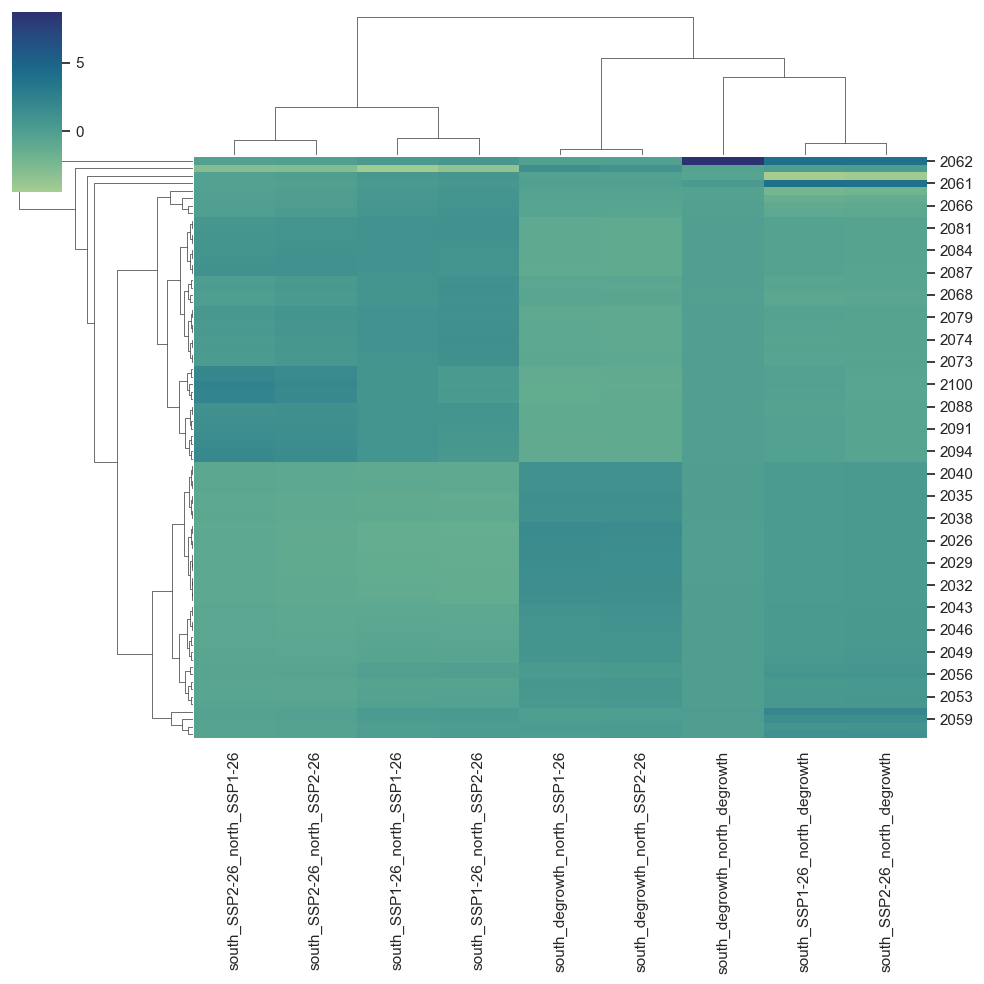

In [28]:

sns.clustermap(nas_indic,z_score=1,cmap="crest")

We normalize the data by the respecitve hightest value to increase visualization potential

Text(0.5, 0, 'NAS south / NAS nord rel to max')

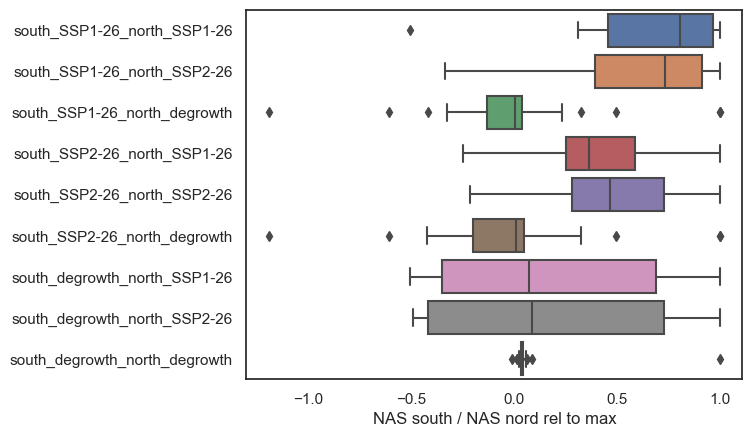

In [29]:
sns.boxplot(nas_indic/nas_indic.max(), orient='h')
plt.xlabel('NAS south / NAS nord rel to max')

In [30]:
print(nas_indic.describe())

       south_SSP1-26_north_SSP1-26  south_SSP1-26_north_SSP2-26   
count                    78.000000                    78.000000  \
mean                      1.963608                     2.290739   
std                       0.799822                     0.989016   
min                      -1.401907                    -1.167528   
25%                       1.257712                     1.371492   
50%                       2.223037                     2.558880   
75%                       2.676145                     3.174869   
max                       2.760997                     3.481622   

       south_SSP1-26_north_degrowth  south_SSP2-26_north_SSP1-26   
count                     78.000000                    78.000000  \
mean                      -1.717725                     1.703936   
std                       13.558725                     0.918205   
min                      -61.736191                    -0.977442   
25%                       -6.939227                     

In [31]:
nas_indic_dic = {(column): np.array(nas_indic[column]) for column in nas_indic.columns}

print(nas_indic_dic)

{'south_SSP1-26_north_SSP1-26': array([-1.40190704,  0.85552884,  0.87271119,  0.89131068,  0.91142574,
        0.93316828,  0.95666644,  0.97281929,  0.9900126 ,  1.00833966,
        1.02790975,  1.04885057,  1.07131078,  1.09546274,  1.12150537,
        1.14966711,  1.18020902,  1.20187377,  1.22532695,  1.25078595,
        1.27849056,  1.30870353,  1.3417106 ,  1.37781973,  1.41735919,
        1.46067423,  1.50812167,  1.54793249,  1.59115223,  1.63795099,
        1.68846206,  1.74276809,  1.800886  ,  1.86275139,  1.92820388,
        1.99697518,  2.0686819 ,  2.13019737,  2.19217752,  2.25389685,
        2.31459197,  2.37349793,  2.42988832,  2.48311512,  2.53264396,
        2.57808078,  2.61918735,  2.65035708,  2.67701388,  2.69930131,
        2.71746684,  2.73183851,  2.74280065,  2.75077075,  2.75617899,
        2.75945137,  2.76099678,  2.75829558,  2.75427774,  2.74922846,
        2.74340414,  2.73703282,  2.73031546,  2.72342782,  2.71652266,
        2.70973195,  2.70316912,

In [32]:
nas_indic_cum = pd.DataFrame()
for scenario in scenarios:
    for scenario_1 in scenarios:
        nas_indic_cum[f"south_{scenario}_north_{scenario_1}"] = agg_sum[f"south_{scenario}"] + agg_sum[f"north_{scenario_1}"]

#nas_indic = nas_indic.fillna(0)  # Replace NaN values with 0


nas_indic_cum['south_SSP1-26_north_degrowth'].loc[2062] = nas_indic_cum['south_SSP1-26_north_degrowth'].loc[2061]
nas_indic_cum['south_SSP2-26_north_degrowth'].loc[2062] = nas_indic_cum['south_SSP2-26_north_degrowth'].loc[2061]



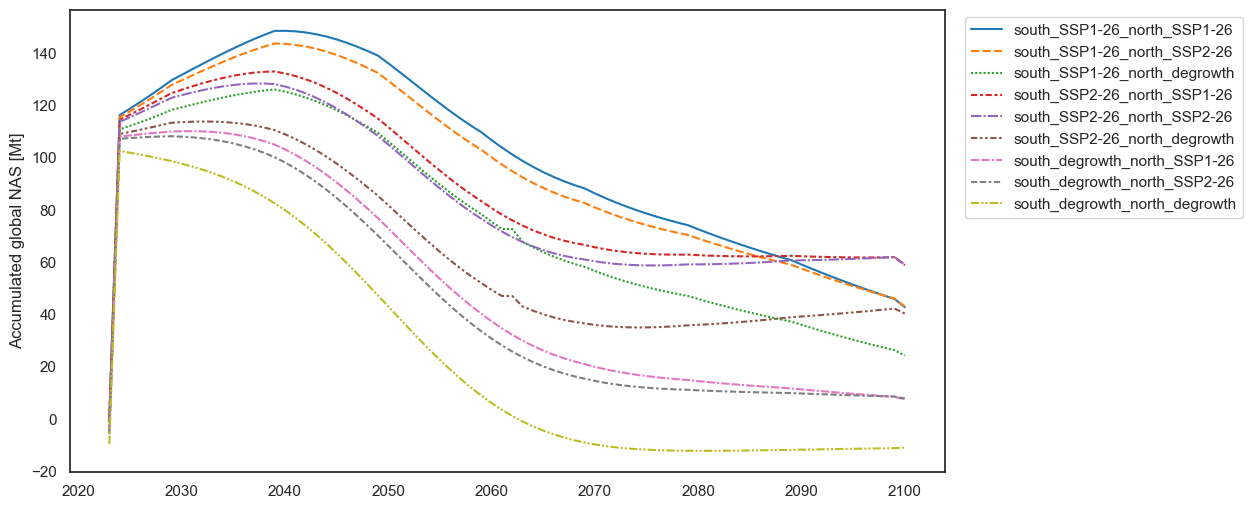

In [41]:
sns.set_style("white")
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your requirement

# Plot the line plot with legend
sns.lineplot(data=nas_indic_cum, palette='tab10')

plt.ylabel('Accumulated global NAS [Mt]')

# Move the legend to the right upper corner
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))

# Scale down the legend
plt.subplots_adjust(right=1)  # Adjust the value to scale down the legend

plt.show()

In [40]:
print(nas_indic_cum)

     south_SSP1-26_north_SSP1-26 south_SSP1-26_north_SSP2-26   
2023                    1.287348                    0.644332  \
2024                  116.358925                  115.539916   
2025                  118.806288                  117.804913   
2026                  121.356081                  120.165862   
2027                  124.007082                  122.621442   
...                          ...                         ...   
2096                   49.973632                   49.590657   
2097                   48.593731                    48.39019   
2098                   47.257881                   47.228417   
2099                   45.966719                    46.10597   
2100                   42.814914                      43.068   

     south_SSP1-26_north_degrowth south_SSP2-26_north_SSP1-26   
2023                    -3.071538                   -0.072256  \
2024                   110.875387                   114.55179   
2025                   112.183912   

Text(0.5, 0, 'NAS cum')

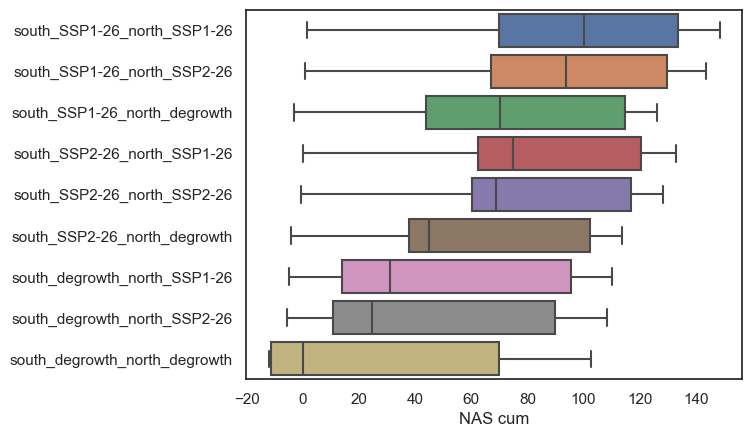

In [34]:
sns.boxplot(nas_indic_cum, orient='h')
plt.xlabel('NAS cum')

In [35]:
print(nas_indic_cum['south_degrowth_north_degrowth'][nas_indic_cum['south_degrowth_north_degrowth']<.1])

2023    -9.491606
2063     -0.91542
2064    -2.781757
2065    -4.421343
2066    -5.847135
2067    -7.074073
2068    -8.118452
2069    -8.997325
2070    -9.727967
2071    -10.32742
2072   -10.812102
2073   -11.197514
2074   -11.498017
2075   -11.726695
2076   -11.895275
2077   -12.014116
2078   -12.092235
2079   -12.137377
2080   -12.156107
2081   -12.153918
2082   -12.135351
2083   -12.104115
2084   -12.063203
2085   -12.015003
2086   -11.961398
2087   -11.903857
2088   -11.843513
2089   -11.781228
2090   -11.717654
2091   -11.653277
2092   -11.588456
2093   -11.523451
2094    -11.45845
2095   -11.393589
2096    -11.32896
2097   -11.264629
2098   -11.200641
2099   -11.137024
2100   -10.929535
Name: south_degrowth_north_degrowth, dtype: object


In [36]:
nas_cum_dic = {(column): nas_indic_cum[column].values for column in nas_indic_cum.columns}

print(nas_cum_dic)

{'south_SSP1-26_north_SSP1-26': array([1.287347939408333, 116.35892532445573, 118.80628756685968,
       121.35608122015776, 124.00708173173015, 126.7570106664986,
       129.60252474723296, 131.70693516278462, 133.80433372202705,
       135.88061898497057, 137.92069253959772, 139.9088262781239,
       141.82912951487222, 143.66611047216006, 145.40531996596786,
       147.03405817613736, 148.54211871130354, 148.57670775174444,
       148.38028186800656, 147.94863863263882, 147.28248947119434,
       146.38786440618986, 145.27634543479988, 143.96510576233007,
       142.4767418787959, 140.83889665836455, 139.08368349195354,
       136.14420777909993, 133.1063651059386, 130.00865909769772,
       126.89034536757705, 123.7903746785859, 120.74637789909035,
       117.79373798755883, 114.96478779951806, 112.28816383006166,
       109.78833582313038, 106.75132667489221, 103.90045003475474,
       101.24614248363481, 98.79461068086533, 96.54818899239802,
       94.50579425402016, 92.663445766